## Custom time imput

In this session we want to demonstrate another feature how to use the TTM and our software, where we want to give special attention to the source term $S(x,t)$ in the coupled heat diffusion equation. 

\begin{align}
C_E \cdot\rho\cdot\partial_t T_E &= \partial_x(k_E(T_E)\partial_x T_E(x,t)) + G(T_L-T_E) + S(x,t) \\ \nonumber
C_L\cdot\rho\cdot\partial_t T_L &= \partial_x(k_L(T_L)\partial_x T_L(x,t)) + G(T_E-T_L)
\end{align}

* We consider, in $S(x,t)$ the time grid of a THz pulse, from data obtained in the lab and map it on the required time grid of the simulation. 
* The spacial decay of the injected energy is computed via Lambert Beer´s law, i.e. exponential decay according to the optical penetration depth. 
* The workflow of this session is as follows:
  * Load the data from the `.txt` file [THz-data](https://github.com/udcm-su/heat-diffusion-1D/blob/master/Examples/THzPulse.txt) and pass it on to the `source()` class. (Here the pulse is a THz in time but in principle it can be anything.)
  * Choose an extra refined time grid around $t_0$ of the pulse to correctly capture the dynamics in time
  * Define a material stack with `addLayer(...)` (here [SRO|STO]).
  * Run the simulation and visualize the output dynamics.


Not required but makes physical units more obvious: [SI-units](https://pypi.org/project/numericalunits/)

In [1]:
from NTMpy import NTMpy as ntm
from matplotlib import pyplot as plt
import numpy as np
import numericalunits as u
u.reset_units('SI')

In [2]:
#SRO- Parameters
length_SRO = 40*u.nm
n_SRO      = 0.5j #Approximation
k_SRO1 = 6*u.W/(u.m*u.K)
k_SRO2 = 1*u.W/(u.m*u.K)
C_SRO1    = lambda Te: 0.112*Te
C_SRO2  = 450
rho_SRO = 6500*u.kg/(u.m**3)
G_SRO   = 5e17*u.W/(u.m**3*u.K)
#STO- Parameters
length_STO = 80*u.nm
n_STO      = 0.5j #Approximation
k_STO1     = 12*u.W/(u.m*u.K)
k_STO2     = 1*u.W/(u.m*u.K)
C_STO1     = lambda Te: 0.025*Te
C_STO2     = 730
rho_STO    = 5100*u.kg/(u.m**3)
G_STO      = 5e17*u.W/(u.m**3*u.K)

In [3]:
# Load data from the lab
labData = np.loadtxt('C:/Users/lUKAS/Documents/UDCM/THzPulse/THzPulse.txt')
ttime   = labData[:,0]*u.ps
ampl    = labData[:,1]
#Define a source
s                           = ntm.source()
s.spaceprofile              = "LB" 
s.timeprofile               = "Custom"
s.fluence                   = 5*u.mJ/u.cm**2    #Fluence of the laser
s.t0                        = 1.5*u.ps          #Approximately the time of THz peak
s.lambda_vac                = 299800            #1THz in nm
s.loadData                  = [ttime,ampl]      #implementing the Data from the lab
s.adjusted_grid             = 'on'              #Injecting more points in the time grid
s.dt0                       = 3*u.ps            #t0-dt0 and t0+dt0 get more points
s.extra_points              = 600               #Amount of extra points

In [4]:
#Two temperatures are considered, electron and lattice
sim = ntm.simulation(2,s)
#add parameters for both layers and both systems
#(lengt, refractive_index, conductivity [electron, lattice], heatCapacity [electron, lattice], density, linear Coupling) 
#SRO Layer
sim.addLayer(length_SRO,n_SRO,[k_SRO1,k_SRO2],[C_SRO1,C_SRO2],rho_SRO,G_SRO) 
#STO Layer
sim.addLayer(length_STO,n_STO,[k_STO1,k_STO2],[C_STO1,C_STO2],rho_STO,G_STO)
sim.final_time = 12*u.ps
#To get the raw output
[spacegrid,timegrid,Tempmap] = sim.run() 
#Create a visual object where the simulation gets passed on 
v = ntm.visual(sim)

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 2.79e-14 s
-----------------------------------------------------------
-----------------------------------------------------------
A refined Grid around t0 has been applied
-----------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 2642.69it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 0.34369754791259766
-----------------------------------------------------------
------------------------------------------------------------
The simulation object of the 2 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
A refined Grid around t0 has been applied
-----------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 2283.25it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 0.39531373977661133
-----------------------------------------------------------


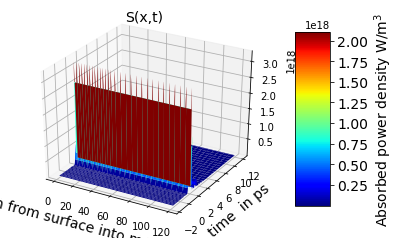

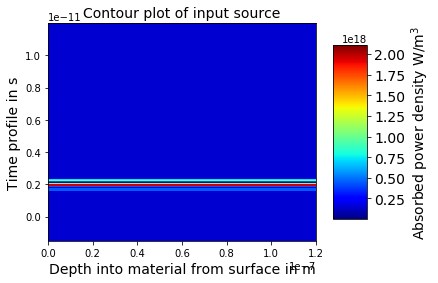

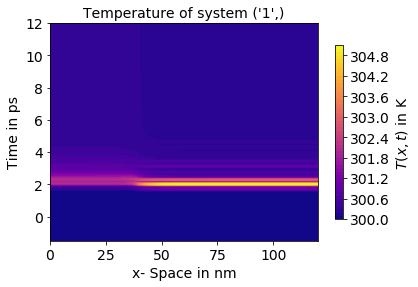

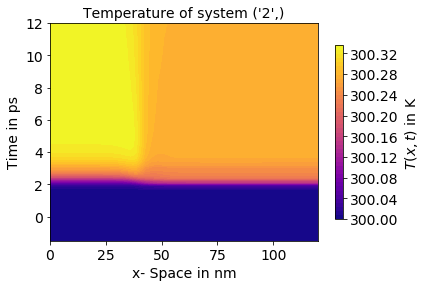

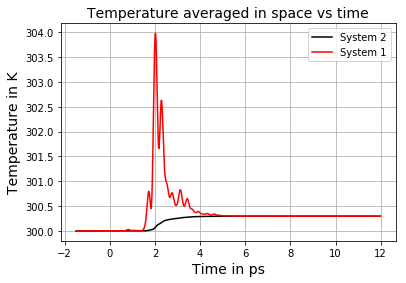

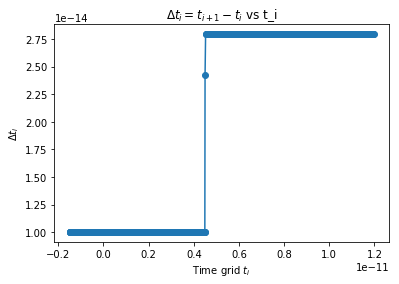

In [5]:
#Output of v.source is the full matrix of the source(x,t)
so = v.source()
#Contour plots to depict heat map in space and time
v.contour('1')# Electronic system
v.contour('2')# Lattice system 
#Time dynamics of Temperature, averaged in space 
[tt,avTemp_vec] = v.average()
#To show the refined time grid
v.timegrid() 

In the plot, where the data gets averaged in space and we can see the dynamics in time, the characteristic shape of a THz- pulse can be seen.

Note however, that formally the wavelength $\lambda_{vac}$ has still be provided to the source input `s.lambda_vac = number` (in nm). 

This is because the decay of the pulse intensity, or how much of the energy gets locally absorbed, with respect to space, is calculated via the refractive index. 

In the example given, the refractive index is not correct, but an assumption, since this data is not easy to obtain in the THz region. 